In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

## PART 1: Login Time Analysis

In [4]:
# Opening the json file

with open('/Users/robertlewis/Desktop/My_Projects/Springboard/ultimate_challenge/logins.json') as logins:
    data = json.load(logins)
    logins.close()
print(data)


{'login_time': ['1970-01-01 20:13:18', '1970-01-01 20:16:10', '1970-01-01 20:16:37', '1970-01-01 20:16:36', '1970-01-01 20:26:21', '1970-01-01 20:21:41', '1970-01-01 20:12:16', '1970-01-01 20:35:47', '1970-01-01 20:35:38', '1970-01-01 20:47:52', '1970-01-01 20:26:05', '1970-01-01 20:31:03', '1970-01-01 20:34:46', '1970-01-01 20:36:34', '1970-01-01 20:39:25', '1970-01-01 20:40:37', '1970-01-01 20:34:58', '1970-01-01 20:43:59', '1970-01-01 20:47:46', '1970-01-01 20:46:34', '1970-01-01 20:56:07', '1970-01-01 20:49:12', '1970-01-01 20:59:06', '1970-01-01 20:59:59', '1970-01-01 21:15:01', '1970-01-01 21:09:24', '1970-01-01 21:19:24', '1970-01-01 21:20:53', '1970-01-01 21:29:19', '1970-01-01 21:58:05', '1970-01-01 21:51:51', '1970-01-01 21:59:40', '1970-01-01 22:08:34', '1970-01-01 22:02:51', '1970-01-01 21:58:32', '1970-01-01 22:02:31', '1970-01-01 22:05:32', '1970-01-01 22:02:46', '1970-01-01 22:10:28', '1970-01-01 22:11:58', '1970-01-01 22:01:05', '1970-01-01 22:19:10', '1970-01-01 22:16:

In [5]:
# Checking if all elements in the login_time dict are of the same type

result = True
for element in data['login_time']:
    if not isinstance(element, type(data['login_time'][0])):
        result = False 
        break
        
print("Do all elements have same type : " + str(result))

Do all elements have same type : True


In [6]:
# Visualize the data

df = pd.DataFrame(data)
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   login_time  93142 non-null  object
dtypes: object(1)
memory usage: 727.8+ KB


In [8]:
dataTypeSeries = df.dtypes
print(dataTypeSeries)

login_time    object
dtype: object


In [9]:
# Converting login times to datetime objects
# and setting them to the index. Adding a 
# 'count' column to aggregate on

df = df.set_index(['login_time'])
df.index = pd.to_datetime(df.index)
df['count'] = 1
df.head()

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [10]:
# Resampling into 15 min intervals

df_resample = df.resample('15min').sum()
df_resample.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


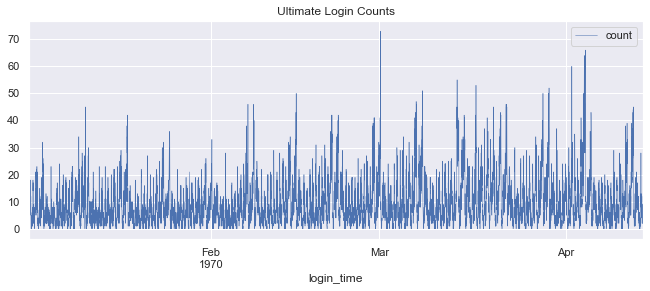

In [24]:
# Visualizing the basic structure of the time series

sns.set(rc={'figure.figsize':(11, 4)})
df_resample.plot(linewidth=0.5).set_title("Ultimate Login Counts");

### The login times seem to show a seasonality component that will be further investigated

In [19]:
# Looking at rolling statistics
# Window = 96 chosen b/c there are 96 intervals of 15 min per day

rollmean = df_resample['count'].rolling(window=96).mean()

rollstd = df_resample['count'].rolling(window=96).std()
print(rollmean, rollstd)

login_time
1970-01-01 20:00:00         NaN
1970-01-01 20:15:00         NaN
1970-01-01 20:30:00         NaN
1970-01-01 20:45:00         NaN
1970-01-01 21:00:00         NaN
                         ...   
1970-04-13 17:45:00    6.718750
1970-04-13 18:00:00    6.677083
1970-04-13 18:15:00    6.552083
1970-04-13 18:30:00    6.510417
1970-04-13 18:45:00    6.458333
Freq: 15T, Name: count, Length: 9788, dtype: float64 login_time
1970-01-01 20:00:00         NaN
1970-01-01 20:15:00         NaN
1970-01-01 20:30:00         NaN
1970-01-01 20:45:00         NaN
1970-01-01 21:00:00         NaN
                         ...   
1970-04-13 17:45:00    4.725526
1970-04-13 18:00:00    4.722833
1970-04-13 18:15:00    4.685633
1970-04-13 18:30:00    4.663396
1970-04-13 18:45:00    4.640591
Freq: 15T, Name: count, Length: 9788, dtype: float64


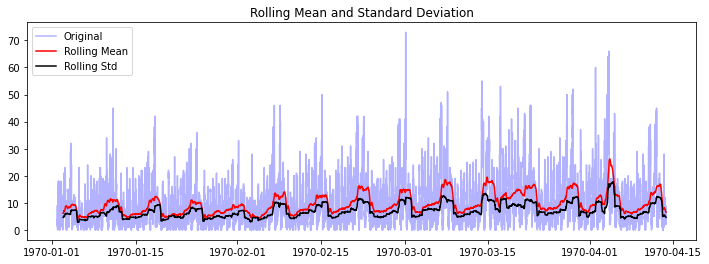

In [20]:
# Plotting the Rolling Data with the Original

plt.figure(figsize=(12, 4))
orig = plt.plot(df_resample, color='blue', label='Original', alpha=0.3)
mean = plt.plot(rollmean, color='red', label='Rolling Mean')
std = plt.plot(rollstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title("Rolling Mean and Standard Deviation")
plt.show(block=False)

### The Rolling mean seems to clearly show a bi-monthly uptick in logins over this 4 month window

In [27]:
# Extracting Day of the Week to see any login trends based
# on days

df_by_login_day = df.resample('D').sum()
df_by_login_day['Weekday'] = pd.DatetimeIndex(df_by_login_day.index).to_series().dt.day_name()
df_by_login_day.head()

,count,Weekday
login_time,,
1970-01-01,112,Thursday
1970-01-02,681,Friday
1970-01-03,793,Saturday
1970-01-04,788,Sunday
1970-01-05,459,Monday


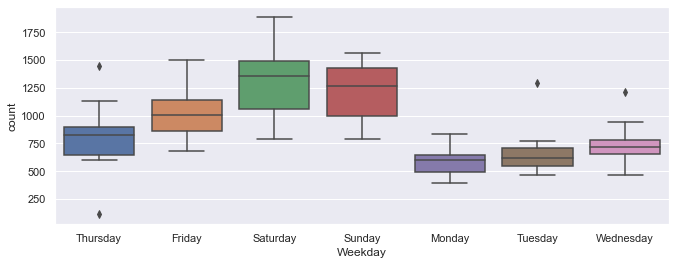

In [23]:
# Visualizing login counts by Day of the Week

sns.set(rc={'figure.figsize':(11, 4)})
ax = sns.boxplot(x="Weekday", y="count", data=df_by_login_day)

### Here we can see that there appears to be a significant uptick in logins on the weekend vs weekdays

----

## PART 2: Experiment and Design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: <b>on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.</b> However, a toll bridge, with a <b>two­way toll</b>, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

### 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

To approach this question, I would first assume that the company has data that can label drivers as either a 'Gotham Driver' or 'Metropolis Driver' based on some variable like their 'starting location' or 'city of origin'.

Once drivers are labelled, I'd next want to use location based tracking data to determine the ratio of Metropolis to Gotham drivers in each city. If drivers are using the bridge, we would be looking for a close to 50/50 mix in either city at any given time. These ratios, for their respective cities, could then be compared to historical data to see if there was a statistically significant change in the number of Gotham drivers in Metropolis and vice versa.  

### 2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success.

In order to approach this question, I would start by focusing only on the Weekends. The thought being that if there is sufficient demand in both Gotham and Metropolis at this time, there should be equal incentive for drivers in both cities. The only potential hesitation that a driver in Gotham/Metropolis may have to venture into the neighboring city is the price of the bridge toll. That is to say that all factors would remain constant with the toll bridge pricing being the isolated variable we want to assess. 

At regularly scheduled time points on Friday, Saturday, and Sunday data could be collected for each city and a simple ratio of Metropolis to Gotham drivers could be collected. To compensate for anomalous factors, the test would be drawn out of several weekends, likely 1 or 2 months. Given that toll compensation would likely be a large financial hit to Ultimate, you would want to collect enough data to be confident that toll compensation is worth pursuing. 

Once the data has been collected, a <b>Paired t-Test</b> can be used to compare the mean of the ratios of the test period with that of historical data to see if there was a significant change in driver behavior. A paired test was chosen bc we'll assume the Drivers in the test period are the same as Drivers before and we want to look at if the variable of paying for tolls changed their behavior or not.

To present this imformation to the city operations team, I would use python to run the test results and conduct any necessary plotting of the data. Next, I would create a Tableau Dashboard to for an easily interpretable format that shows several key metrics, outside of the ratio comparisons. This would include things such as: Number of Drivers on the road (i.e. Did supply of drivers go up?), Number of Weekly Toll Crossing w/ corresponding Cost (Important to decide if the benefits outweigh the cost), Avgerage Rider Wait Time (Did more drivers crossing lead to shorter waits for riders?), perhaps a map of the two cities that shows driver amounts colored by city of origin. This dashboard would finally be filterable by 'Friday/Saturday/Sunday' and 'Test Period / 'Historically'


---

## PART 3: Rider Retention Predictive Modeling 

In [29]:
rider_df = pd.read_json('/Users/robertlewis/Desktop/My_Projects/Springboard/ultimate_challenge/ultimate_data_challenge.json')

print(rider_df.head(10))

             city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   
5      Winterfell                       2  2014-01-09                   3.5   
6         Astapor                       1  2014-01-24                   NaN   
7      Winterfell                       2  2014-01-28                   5.0   
8      Winterfell                       2  2014-01-21                   4.5   
9      Winterfell                       1  2014-01-03                   NaN   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4           

In [30]:
# Getting an overview of the dataset

rider_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [31]:
# Checking for nulls

rider_df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

#### Avg Rating of Driver / Avg Rating By Driver and Phone Numbers appear to be missing

In [32]:
rider_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [33]:
# Converting the Boolean column to an Integer for better processing

rider_df['ultimate_black_user'] = rider_df['ultimate_black_user'].astype(int)

<AxesSubplot:>

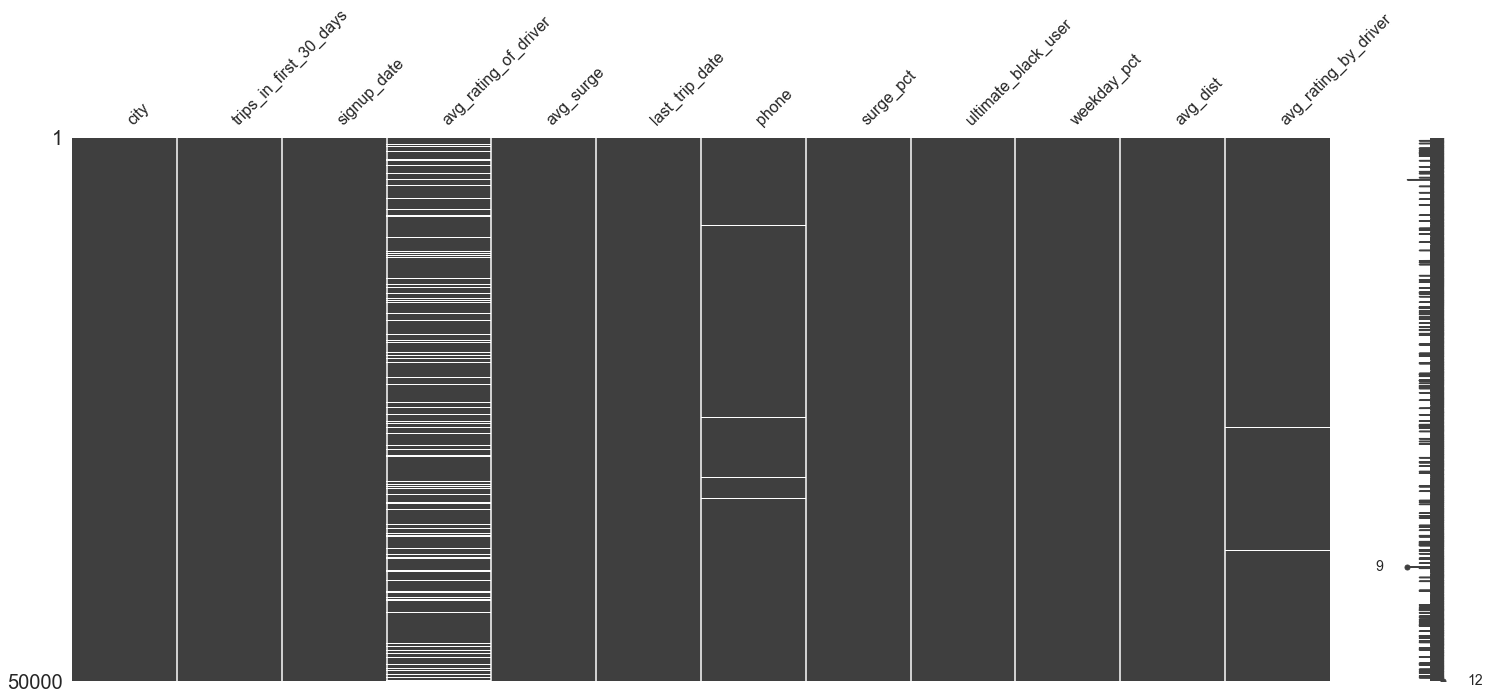

In [34]:
# Visualize missing values as a matrix

msno.matrix(rider_df)

### There is a distinct difference in the way missing values are distributed between the avg_rating_of_driver , phone , and avg_rating_by_driver features

In [35]:
# Imputing NaNs in the avg_rating_by_driver with Median values
# Since there are few missing values, imputing with median values
# shouldn't have a large impact on the data

rider_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
rider_df[['avg_rating_by_driver']] = rider_imputer.fit_transform(rider_df[['avg_rating_by_driver']])

In [36]:
# Understanding how the 'Phone' col is divided to better determine how best to handle
# missing values

round(rider_df['phone'].value_counts(normalize=True) * 100, 2)

iPhone     69.72
Android    30.28
Name: phone, dtype: float64

In [37]:
# Because of the 70/30 breakdown of phone types and only around 400 
# missing values, replacing with the most frequent occurance
# Since this can bias the data, may come back to this 

rider_df['phone'].fillna(rider_df['phone'].mode()[0], inplace = True)
print(round(rider_df['phone'].value_counts(normalize=True) * 100, 2))
print(rider_df['phone'].isna().sum())

iPhone     69.96
Android    30.04
Name: phone, dtype: float64
0


Since using Mode to fill in missing values didn't change our initial distribution of phone types, we'll continue

In [38]:
rider_df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                        0
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver         0
dtype: int64

In [39]:
# Driver ratings could be missing for a number a reasons. Such as: Rider forgot to
# rate the driver, Rider has signed up but not yet taken a ride, 

missing_driver_rating = rider_df[rider_df['avg_rating_of_driver'].isnull()]
print(missing_driver_rating.sample(n=10))

                 city  trips_in_first_30_days signup_date  \
6231       Winterfell                       0  2014-01-16   
22761      Winterfell                       1  2014-01-25   
27018      Winterfell                       1  2014-01-21   
5488       Winterfell                       0  2014-01-27   
48436      Winterfell                       0  2014-01-31   
41455  King's Landing                       0  2014-01-17   
3992       Winterfell                       1  2014-01-10   
46242         Astapor                       1  2014-01-15   
32925         Astapor                       0  2014-01-11   
27868      Winterfell                       0  2014-01-09   

       avg_rating_of_driver  avg_surge last_trip_date    phone  surge_pct  \
6231                    NaN       1.00     2014-03-07   iPhone        0.0   
22761                   NaN       1.00     2014-04-05  Android        0.0   
27018                   NaN       1.00     2014-01-22   iPhone        0.0   
5488                

In [40]:
# Looking at data for rider whose 'signup date' and 'last_trip_date' are equal
# to see if those with no avg_rating_of_driver simply haven't taken their first trip  yet

missing_driver_rating.loc[missing_driver_rating['signup_date'] == missing_driver_rating['last_trip_date']]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
95,Astapor,1,2014-01-23,NaN,1.0,2014-01-23,iPhone,0.0,1,100.0,1.35,4.0
191,Winterfell,1,2014-01-29,NaN,1.0,2014-01-29,Android,0.0,0,100.0,1.34,5.0
215,Winterfell,1,2014-01-24,NaN,1.0,2014-01-24,iPhone,0.0,1,100.0,19.77,4.0
238,Astapor,1,2014-01-18,NaN,1.0,2014-01-18,Android,0.0,0,0.0,5.72,5.0
271,Astapor,1,2014-01-30,NaN,1.0,2014-01-30,Android,0.0,1,100.0,2.32,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
49519,Winterfell,1,2014-01-11,NaN,2.0,2014-01-11,Android,100.0,0,0.0,5.97,5.0
49738,Winterfell,1,2014-01-10,NaN,3.0,2014-01-10,iPhone,100.0,0,100.0,4.48,5.0
49742,Winterfell,1,2014-01-02,NaN,1.0,2014-01-02,iPhone,0.0,0,100.0,5.40,5.0
49778,Winterfell,1,2014-01-14,NaN,1.0,2014-01-14,iPhone,0.0,0,100.0,13.94,5.0


All riders that are missing an avg_rating_of_driver value have riden at least once since signing up

<AxesSubplot:>

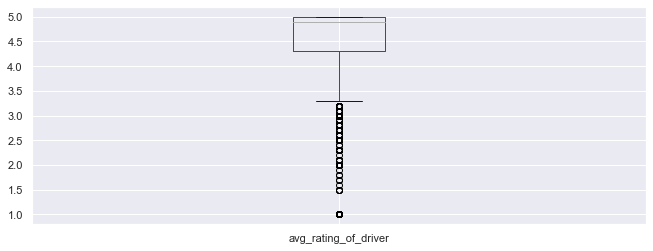

In [41]:
# Visualizing how avg_rating_of_driver is broken down

rider_df.boxplot(column='avg_rating_of_driver')

In [42]:
# What percent of riders have given a rating below 3.25?

LowDriverRating = rider_df[rider_df['avg_rating_of_driver'] <= 3.25]
HighDriverRating = rider_df[rider_df['avg_rating_of_driver'] > 3.25]

print((len(LowDriverRating) / len(rider_df)) * 100)

3.592


#### Eventhough most ratings fall well within the 4.2 and above range, it's important to still keep the lower ratings intact when using in our model since we're looking at whether this has an impact in retention.

### Imputing avg_rating_of_driver using KNN

Because there doesn't seem to be a straightforward way to impute the missing values in this feature without data leakage, we'll look to using kNN. The idea in kNN methods is to identify ‘k’ samples in the dataset that are similar or close in the space. Then we use these ‘k’ samples to estimate the value of the missing data points. Each sample’s missing values are imputed using the mean value of the ‘k’-neighbors found in the dataset.

In [43]:
from sklearn.impute import KNNImputer

imp_rider_df = rider_df.drop(['signup_date', 'last_trip_date'], axis=1)

In [44]:
imp_rider_df.isna().sum()

city                         0
trips_in_first_30_days       0
avg_rating_of_driver      8122
avg_surge                    0
phone                        0
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver         0
dtype: int64

In [45]:
# Creating dummy variables

cat_variables = imp_rider_df[['city','phone', 'ultimate_black_user']]
cat_dummies = pd.get_dummies(cat_variables, drop_first=True)
cat_dummies.head()

,ultimate_black_user,city_King's Landing,city_Winterfell,phone_iPhone
0,1,1,0,1
1,0,0,0,0
2,0,0,0,1
3,1,1,0,1
4,0,0,1,0


In [46]:
# Removing redundant cols and adding our dummy features back to the dataframe

imp_rider_df = imp_rider_df.drop(['city','phone', 'ultimate_black_user'], axis=1)
imp_rider_df = pd.concat([imp_rider_df, cat_dummies], axis=1)
imp_rider_df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,ultimate_black_user,city_King's Landing,city_Winterfell,phone_iPhone
0,4,4.7,1.10,15.4,46.2,3.67,5.0,1,1,0,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,0,0,0,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,0,0,0,1
3,9,4.6,1.14,20.0,80.0,2.36,4.9,1,1,0,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,0,1,0


In [47]:
# Scaling the features

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 
imp_rider_df = pd.DataFrame(scaler.fit_transform(imp_rider_df), columns = imp_rider_df.columns)
imp_rider_df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,ultimate_black_user,city_King's Landing,city_Winterfell,phone_iPhone
0,0.032,0.925,0.014286,0.154,0.462,0.022801,1.000,1.0,1.0,0.0,1.0
1,0.000,1.000,0.000000,0.000,0.500,0.051317,1.000,0.0,0.0,0.0,0.0
2,0.024,0.825,0.000000,0.000,1.000,0.004784,1.000,0.0,0.0,0.0,1.0
3,0.072,0.900,0.020000,0.200,0.800,0.014662,0.975,1.0,1.0,0.0,1.0
4,0.112,0.850,0.027143,0.118,0.824,0.019446,0.975,0.0,0.0,1.0,0.0


In [48]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5) #instantiate the imputer
imp_rider_df = pd.DataFrame(imputer.fit_transform(imp_rider_df),columns = imp_rider_df.columns) #fit and transform

In [49]:
imp_rider_df.isna().sum()

trips_in_first_30_days    0
avg_rating_of_driver      0
avg_surge                 0
surge_pct                 0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
ultimate_black_user       0
city_King's Landing       0
city_Winterfell           0
phone_iPhone              0
dtype: int64

In [50]:
Min = rider_df.drop(['city', 'signup_date', 'last_trip_date', 'phone', 'ultimate_black_user'], axis=1).min()
Max = rider_df.drop(['city', 'signup_date', 'last_trip_date', 'phone', 'ultimate_black_user'], axis=1).max()
Range = Max - Min
print(Min['avg_rating_of_driver'] , Max['avg_rating_of_driver'] , Range['avg_rating_of_driver'])

1.0 5.0 4.0


In [51]:
# Because the data had to be scaled to use kNN, we'll now 'reverse' our feature of choice to get ratings

unscaled_rating = imp_rider_df['avg_rating_of_driver'] * Range['avg_rating_of_driver'] + Min['avg_rating_of_driver']
type(unscaled_rating)

pandas.core.series.Series

In [52]:
dates = rider_df[['signup_date', 'last_trip_date']]

clean_rider_df = pd.concat([imp_rider_df, dates], axis=1)
clean_rider_df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,ultimate_black_user,city_King's Landing,city_Winterfell,phone_iPhone,signup_date,last_trip_date
0,0.032,0.925,0.014286,0.154,0.462,0.022801,1.000,1.0,1.0,0.0,1.0,2014-01-25,2014-06-17
1,0.000,1.000,0.000000,0.000,0.500,0.051317,1.000,0.0,0.0,0.0,0.0,2014-01-29,2014-05-05
2,0.024,0.825,0.000000,0.000,1.000,0.004784,1.000,0.0,0.0,0.0,1.0,2014-01-06,2014-01-07
3,0.072,0.900,0.020000,0.200,0.800,0.014662,0.975,1.0,1.0,0.0,1.0,2014-01-10,2014-06-29
4,0.112,0.850,0.027143,0.118,0.824,0.019446,0.975,0.0,0.0,1.0,0.0,2014-01-27,2014-03-15


In [53]:
clean_rider_df[['signup_date','last_trip_date']] = clean_rider_df[['signup_date','last_trip_date']].apply(pd.to_datetime, format='%Y-%m-%d')

In [54]:
# Since we weren't told what day this data was pulled,
# we'll use the max 'last_trip_date' as the pull date value
# to further calculate a retention column

pull_date = clean_rider_df['last_trip_date'].max()
print(pull_date)

2014-07-01 00:00:00


In [55]:
clean_rider_df['retained'] = clean_rider_df['last_trip_date'].ge(pull_date - pd.Timedelta(30, 'd'))
clean_rider_df['retained'] = clean_rider_df['retained'].astype(int)
clean_rider_df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,ultimate_black_user,city_King's Landing,city_Winterfell,phone_iPhone,signup_date,last_trip_date,retained
0,0.032,0.925,0.014286,0.154,0.462,0.022801,1.000,1.0,1.0,0.0,1.0,2014-01-25,2014-06-17,1
1,0.000,1.000,0.000000,0.000,0.500,0.051317,1.000,0.0,0.0,0.0,0.0,2014-01-29,2014-05-05,0
2,0.024,0.825,0.000000,0.000,1.000,0.004784,1.000,0.0,0.0,0.0,1.0,2014-01-06,2014-01-07,0
3,0.072,0.900,0.020000,0.200,0.800,0.014662,0.975,1.0,1.0,0.0,1.0,2014-01-10,2014-06-29,1
4,0.112,0.850,0.027143,0.118,0.824,0.019446,0.975,0.0,0.0,1.0,0.0,2014-01-27,2014-03-15,0


-----

## What fraction of the observed users were retained?

In [56]:
pct_retained = round((len(clean_rider_df[clean_rider_df['retained'] == 1]) / len(clean_rider_df)) * 100, 2)

print('The percent of users retained was: {}% '.format(pct_retained))

The percent of users retained was: 37.61% 


----

## Creating a Predictive Model for User Retention

In [41]:
rider_df.columns # Doing this to prevent scrolling up all the time

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'],
      dtype='object')

In [42]:
clean_rider_df.columns # Doing this to prevent scrolling up all the time

Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver',
       'ultimate_black_user', 'city_King's Landing', 'city_Winterfell',
       'phone_iPhone', 'signup_date', 'last_trip_date', 'retained'],
      dtype='object')

In [57]:
df1 = rider_df[['trips_in_first_30_days', 'avg_surge', 'surge_pct', 'weekday_pct', \
                'avg_dist', 'signup_date', 'last_trip_date', 'avg_rating_by_driver']]
df2 = unscaled_rating
df3 = cat_dummies.drop(["city_King's Landing", "city_Winterfell"], axis=1)
df4 = clean_rider_df[["city_King's Landing", "city_Winterfell", 'retained']]

final_df = pd.concat([df1, df2, df3, df4], axis=1)

In [58]:
final_df.isna().sum()

trips_in_first_30_days    0
avg_surge                 0
surge_pct                 0
weekday_pct               0
avg_dist                  0
signup_date               0
last_trip_date            0
avg_rating_by_driver      0
avg_rating_of_driver      0
ultimate_black_user       0
phone_iPhone              0
city_King's Landing       0
city_Winterfell           0
retained                  0
dtype: int64

In [59]:
# Final contructed dataset for modeling

final_df.head()

,trips_in_first_30_days,avg_surge,surge_pct,weekday_pct,avg_dist,signup_date,last_trip_date,avg_rating_by_driver,avg_rating_of_driver,ultimate_black_user,phone_iPhone,city_King's Landing,city_Winterfell,retained
0,4,1.10,15.4,46.2,3.67,2014-01-25,2014-06-17,5.0,4.7,1,1,1.0,0.0,1
1,0,1.00,0.0,50.0,8.26,2014-01-29,2014-05-05,5.0,5.0,0,0,0.0,0.0,0
2,3,1.00,0.0,100.0,0.77,2014-01-06,2014-01-07,5.0,4.3,0,1,0.0,0.0,0
3,9,1.14,20.0,80.0,2.36,2014-01-10,2014-06-29,4.9,4.6,1,1,1.0,0.0,1
4,14,1.19,11.8,82.4,3.13,2014-01-27,2014-03-15,4.9,4.4,0,0,0.0,1.0,0


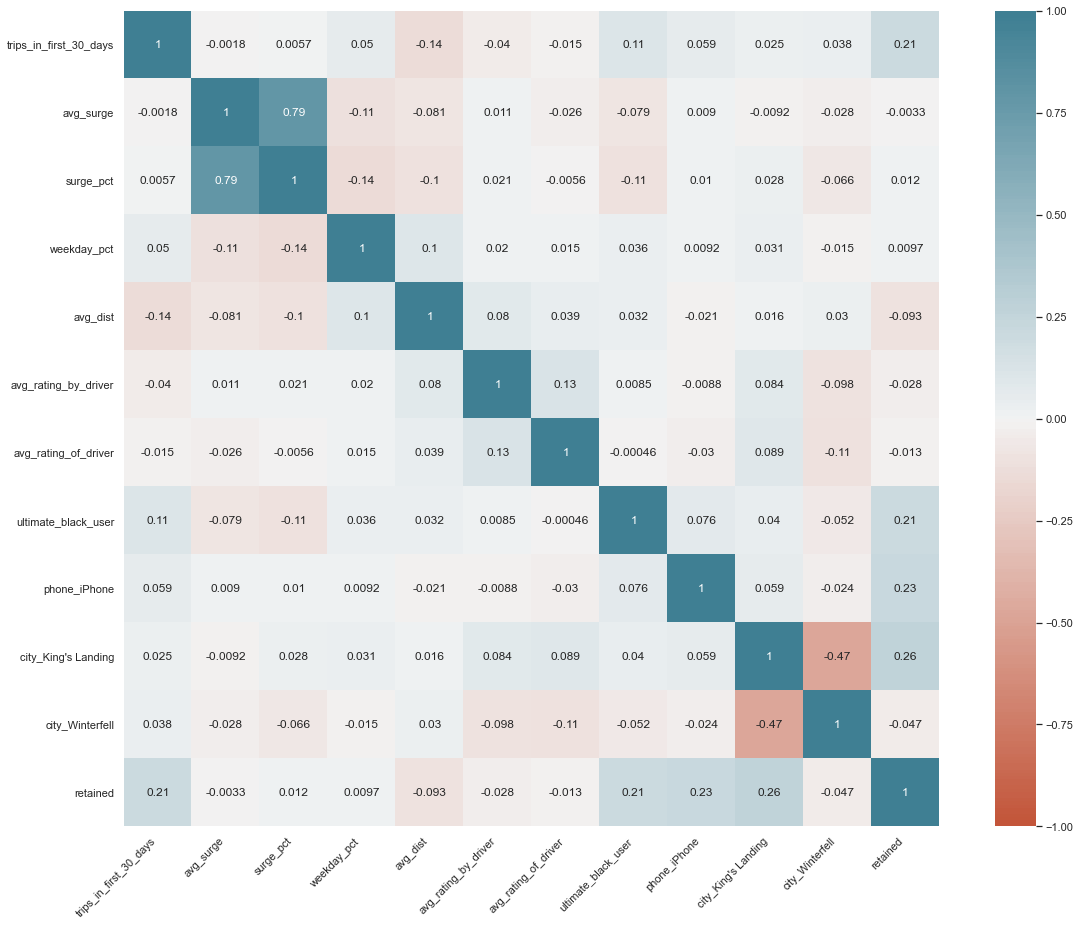

In [60]:
# Looking at if any features can be removed due to redundant info (i.e. features that are correlated)

corr = final_df.corr()

fig, ax = plt.subplots(figsize=(20,15))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [61]:
# Import model and metrics

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix , classification_report, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score

In [62]:
# Create X and y variables

X = final_df.drop(columns=['signup_date', 'last_trip_date', 'retained'])
y = final_df['retained']

In [63]:
# Train Test Split and Scaling data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)


In [64]:
# Checking shape of the train and testing sets

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(40000, 11)
(40000,)
(10000, 11)
(10000,)


In [81]:
#applying SelectKBest class to extract top 8 best features

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(score_func=chi2, k=8)
fit = bestfeatures.fit(X_train_scaled,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train_scaled.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(8,'Score'))  #print 8 best features

                     Specs        Score
9      city_King's Landing  2156.239562
7      ultimate_black_user  1056.000747
8             phone_iPhone   611.617693
0   trips_in_first_30_days    89.346734
10         city_Winterfell    36.728079
4                 avg_dist    14.995192
2                surge_pct     3.846368
3              weekday_pct     0.708973


In [65]:
X = final_df[["city_King's Landing", 'ultimate_black_user', "phone_iPhone", "trips_in_first_30_days", \
             "city_Winterfell", "avg_dist", "surge_pct", "weekday_pct"]]
y = final_df['retained']

In [66]:
# Train Test Split and Scaling data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42) 
# stratify=y is passed in to ensure train and test split have equal distributions of target variable

scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

# Checking shape of the train and testing sets

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(40000, 8)
(40000,)
(10000, 8)
(10000,)


In [67]:
#import machine learning related libraries

from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [107]:
#create an array of baseline models

models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier(use_label_encoder=False, objective='binary:logistic', eval_metric='logloss')))
models.append(("KNN",KNeighborsClassifier()))

In [108]:
#measure the accuracy 

for name,model in models:
    
    kfold = KFold(n_splits=3, random_state=42, shuffle=True)
    cv_result = cross_val_score(model,X_train_scaled,y_train, cv = kfold, scoring = 'roc_auc')
    print(name, cv_result)

LR [0.75121146 0.76339826 0.76356936]
NB [0.76014457 0.76802247 0.77356598]
RF [0.79416861 0.7954354  0.79700211]
SVC [0.78393307 0.78472312 0.7955314 ]
Dtree [0.68313252 0.68003734 0.67956606]
XGB [0.84177855 0.84348022 0.84973228]
KNN [0.79148782 0.79517303 0.7954533 ]


There were several frontrunners in the initial test of baseline models. For this project, we'll move forward with Random Forest, SVC, and XGBoost. 

---

# Random Forest Tuning

In [68]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [69]:
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [70]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.3min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 12, 23, 34, 45, 56, 67,
                                                      78, 89, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 66, 83, 100, 116,
                                                         133, 150, 166, 183,
                                                         200]},
                   random_state=42, verbose=2)

In [71]:
rfc = RandomForestClassifier(n_estimators = 10, random_state = 42)
rfc.fit(X_train_scaled, y_train)
y_pred_test = rfc.predict(X_test_scaled)
print(classification_report(y_test, y_pred_test))
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_test)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred_test)}')

              precision    recall  f1-score   support

           0       0.77      0.80      0.79      6239
           1       0.65      0.60      0.63      3761

    accuracy                           0.73     10000
   macro avg       0.71      0.70      0.71     10000
weighted avg       0.73      0.73      0.73     10000

Confusion Matrix: 
[[5009 1230]
 [1486 2275]]
Area Under Curve: 0.7038726685954785


In [72]:
best_random = rf_random.best_estimator_
y_pred_test = best_random.predict(X_test_scaled)
print(classification_report(y_test, y_pred_test))
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_test)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred_test)}')

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      6239
           1       0.74      0.64      0.68      3761

    accuracy                           0.78     10000
   macro avg       0.77      0.75      0.76     10000
weighted avg       0.78      0.78      0.78     10000

Confusion Matrix: 
[[5394  845]
 [1366 2395]]
Area Under Curve: 0.7506801761048928


Feature: 0, Score: 0.13452
Feature: 1, Score: 0.07065
Feature: 2, Score: 0.08024
Feature: 3, Score: 0.11761
Feature: 4, Score: 0.02115
Feature: 5, Score: 0.15097
Feature: 6, Score: 0.19202
Feature: 7, Score: 0.23286


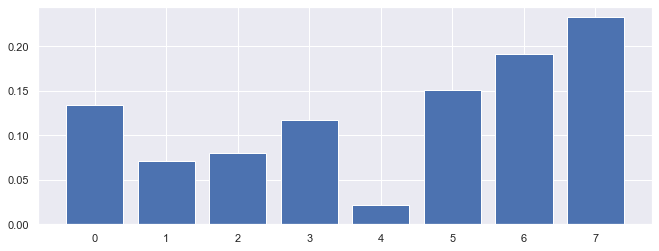

In [76]:
# Getting Feature Importance
importance = best_random.feature_importances_

# Summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# Plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

----

# SVC Tuning

In [117]:
# Create a parameter grid

param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

In [120]:
# Use GridSearchCV to search for best hyperparameters
# First create the base model to tune
svc = SVC()
# Grid search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
svc_search = GridSearchCV(estimator = svc, param_grid = param_grid, cv = 3, verbose=2, n_jobs = -1)
# Fit the grid search model
svc_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  8.7min finished


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             verbose=2)

In [122]:
svc_base = SVC( C= 10, kernel='linear')
svc_base.fit(X_train_scaled, y_train)
y_pred_test = svc_base.predict(X_test_scaled)
print(classification_report(y_test, y_pred_test))
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_test)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred_test)}')

              precision    recall  f1-score   support

           0       0.71      0.86      0.78      6239
           1       0.65      0.42      0.51      3761

    accuracy                           0.70     10000
   macro avg       0.68      0.64      0.64     10000
weighted avg       0.69      0.70      0.68     10000

Confusion Matrix: 
[[5386  853]
 [2192 1569]]
Area Under Curve: 0.6402278272988324


In [123]:
best_search = svc_search.best_estimator_
y_pred_test = best_search.predict(X_test_scaled)
print(classification_report(y_test, y_pred_test))
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_test)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred_test)}')

              precision    recall  f1-score   support

           0       0.73      0.89      0.80      6239
           1       0.71      0.45      0.55      3761

    accuracy                           0.72     10000
   macro avg       0.72      0.67      0.67     10000
weighted avg       0.72      0.72      0.71     10000

Confusion Matrix: 
[[5541  698]
 [2074 1687]]
Area Under Curve: 0.6683370069796652


----

# XGBoost Tuning

In [127]:
xgb_param_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [128]:
from xgboost import XGBClassifier

# Use GridSearchCV to search for best hyperparameters
# First create the base model to tune
xgb = XGBClassifier(objective= 'binary:logistic',nthread=4 ,use_label_encoder=False, seed=42)
# Grid search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgb_search = GridSearchCV(estimator = xgb, param_grid = xgb_param_grid, scoring = 'roc_auc', cv = 5, verbose=2, n_jobs = -1)
# Fit the grid search model
xgb_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 12.4min finished


[20:22:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...e, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=42,
                                     subsample=None

In [132]:
xgb_base = XGBClassifier(objective= 'binary:logistic',nthread=4 ,use_label_encoder=False, \
                         max_depth = 2, n_estimators = 60, learning_rate = 0.1, eval_metric='logloss', seed=42)
xgb_base.fit(X_train_scaled, y_train)
y_pred_test = xgb_base.predict(X_test_scaled)
print(classification_report(y_test, y_pred_test))
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_test)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred_test)}')

              precision    recall  f1-score   support

           0       0.78      0.88      0.82      6239
           1       0.74      0.58      0.65      3761

    accuracy                           0.77     10000
   macro avg       0.76      0.73      0.74     10000
weighted avg       0.76      0.77      0.76     10000

Confusion Matrix: 
[[5477  762]
 [1580 2181]]
Area Under Curve: 0.7288820027582499


In [133]:
xgb_best_search = xgb_search.best_estimator_
y_pred_test = xgb_best_search.predict(X_test_scaled)
print(classification_report(y_test, y_pred_test))
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_test)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred_test)}')

              precision    recall  f1-score   support

           0       0.81      0.86      0.84      6239
           1       0.75      0.66      0.70      3761

    accuracy                           0.79     10000
   macro avg       0.78      0.76      0.77     10000
weighted avg       0.78      0.79      0.78     10000

Confusion Matrix: 
[[5396  843]
 [1284 2477]]
Area Under Curve: 0.7617418142237171


-----

# Conclusions and Recommendations

For the 3 model types tested, Random Forest performed the best. Not only was the AUC the highest, but in Precision, Recall, and F1-Score it was more likely to identify our retained users.

If moving forward with this model, several things could be done to further improve the model. First, a broader set of hyperparameters could be tried which could lead to better results (although probably only slightly). Second, since our percent of retained users is roughly 40 pct, we have a slight class imbalance in the data. There are a couple of options to remedy this that could be tried. We could upsample the minority class by either duplicating data from the retained users and adding them to the dataset (sampling with replacement). We could downsample the majority class, but this could lead to information loss. Or, lastly, you could try using Synthetic Minority Over-sampling Technique (SMOTE) to generate synthetic samples.

In our model, factors that lead to higher retention included: # of rides in first 30 days, iPhone users, pct of surge rides, avg distance, and located in King's Landing.

Some suggestions would be:

    - Offer a reduced price for first month after signing up
    - Look at Android users to identify potential pain points in UI
    - Create a program that rewards users based on taking surge rides and distance travelled 
    - Shift marketing budget to favor people in King's Landing